# Logistic Regression - Binary Sentiment Analysis

In this series we'll be building a machine learning model to detect sentiment (i.e. detect if a sentence is positive or negative) using PyTorch and TorchText. This will be done on movie reviews, using the [IMDb dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

In this first notebook, we'll start very simple to understand the general concepts whilst not really caring about good results. Further notebooks will build on this knowledge and we'll actually get good results.

One main concept of TorchText is `Field`. It define how the data should be processed. In binary sentiment classification, the data consists of both the raw string of the review and the sentiment, either 'pos'(+) or 'neg'(-). We use the `TEXT` field to define how the review should be processed, and the `LABEL` field to process the sentiment. 

Our `TEXT` field has `tokenize='spacy'` as an argument. This defines that the "tokenization" (the act of splitting the string into discrete "tokens") should be done using the [spaCy](https://spacy.io) tokenizer. If no `tokenize` argument is passed, the default is simply splitting the string on spaces.

`LABEL` is defined by a `LabelField`, a special subset of the `Field` class specifically used for handling labels. We will explain the `dtype` argument later. For more on `Fields`, go [here](https://github.com/pytorch/text/tree/master)

We also set the random seeds for reproducibility.

Another handy feature of [TorchText](https://pytorch.org/text/stable/index.html) is that it has support for common datasets used in natural language processing (NLP).

## 1. Data importing and preprocessing

In [2]:
import torch
from torchtext.legacy import data

SEED = 888
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

Another handy feature of TorchText is that it has support for common datasets used in natural language processing (NLP).

The following code automatically downloads the IMDb dataset and splits it into the canonical train/test splits as torchtext.datasets objects. It process the data using the Fields we have previously defined. The IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review.

In [3]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

Let us see how many examples are in each split by checking theri length.

In [4]:
print('Number of training example: {}'.format(len(train_data)))
print('Number of test example: {}'.format(len(test_data)))

Number of training example: 25000
Number of test example: 25000


check on one example

In [5]:
print(vars(train_data.examples[0]))

{'text': ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy', '.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', ',', 'such', 'as', '"', 'Teachers', '"', '.', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', 'High', "'s", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"', 'Teachers', '"', '.', 'The', 'scramble', 'to', 'survive', 'financially', ',', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', 'teachers', "'", 'pomp', ',', 'the', 'pettiness', 'of', 'the', 'whole', 'situation', ',', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students', '.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school', ',', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High', '.', 'A', 'classic', 'l

The datasets do not have a validation set. here we have to do another split from the train_data with a split ratio of 80% to 20%

Generate the validation set with a `split_ratio` of 0.8 would mean 80% of the examples make up the training set and 20% make up the validation set.


In [6]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED), split_ratio =0.8)

In [7]:
print('Number of training example: {}'.format(len(train_data)))
print('Number of validation example: {}'.format(len(valid_data)))
print('Number of test example: {}'.format(len(test_data)))

Number of training example: 20000
Number of validation example: 5000
Number of test example: 25000


Next, we have to build a vocabulary. This is a effectively a look up table where every unique word in your data set has a corresponding index (an integer).

We do this as our machine learning model cannot operate on strings, only numbers. Each index is used to construct a one-hot vector for each word. A one-hot vector is a vector where all of the elements are 0, except one, which is 1, and dimensionality is the total number of unique words in your vocabulary, commonly denoted by $V$.

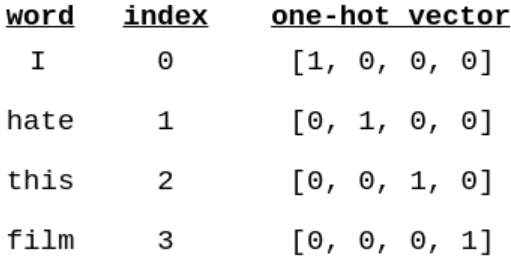

The number of unique words in our training set is over 100,000, which means that our one-hot vectors will have over 100,000 dimensions! This will make training slow and possibly won't fit onto your GPU (if you're using one).

There are two ways effectively cut down our vocabulary, we can either only take the top $n$ most common words or ignore words that appear less than $m$ times. We'll do the former, only keeping the top 25,000 words.

What do we do with words that appear in examples but we have cut from the vocabulary? We replace them with a special unknown or <unk> token. For example, if the sentence was "This film is great and I love it" but the word "love" was not in the vocabulary, it would become "This film is great and I `<unk>` it".

The following builds the vocabulary, only keeping the most common `max_size` tokens.

In [8]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

# unique tokens
print('Unique token in TEXT vocabulary: {}'.format(len(TEXT.vocab)))
print('Unique tokens in LABEL vovabulaary: {}'.format(len(LABEL.vocab)))

Unique token in TEXT vocabulary: 25002
Unique tokens in LABEL vovabulaary: 2


Why is the vocab size 25002 and not 25000? One of the addition tokens is the <unk> token and the other is a <pad> token.
    
When we feed sentences into our model, we feed a batch of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.   

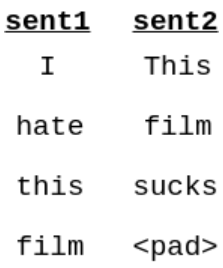

We can also view the most common words in the vocabulary and their frequencies.

In [9]:
# Let print the most common words

print(TEXT.vocab.freqs.most_common(20))

[('the', 232021), (',', 220313), ('.', 189403), ('and', 125229), ('a', 124866), ('of', 115108), ('to', 107110), ('is', 87400), ('in', 70213), ('I', 61961), ('it', 61235), ('that', 56337), ('"', 51288), ("'s", 49839), ('this', 48282), ('-', 42839), ('/><br', 40653), ('was', 40244), ('as', 34894), ('with', 34162)]


We can also see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.

In [10]:
# int to sting
# let print the first 20

print(TEXT.vocab.itos[:20])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is', 'in', 'I', 'it', 'that', '"', "'s", 'this', '-', '/><br', 'was']


In [11]:
# stirng to int
# pos and neg in labels

print(LABEL.vocab.stoi)

defaultdict(None, {'pos': 0, 'neg': 1})


The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a `BucketIterator` which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using `torch.device`, we then pass this device to the iterator.

In [49]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

In [35]:
# check the pos and neg distrubution in the data

labels = [int(vars(train_data.examples[i])['label'] == 'pos') for i in range(len(train_data.examples))]
print("Proportion of training prositives: {:.4f}".format(100* sum(labels)/len(labels)))

labels = [int(vars(valid_data.examples[i])['label'] == 'pos') for i in range(len(valid_data.examples))]
print("Proportion of validation prositives: {:.4f}".format(100* sum(labels)/len(labels)))

labels = [int(vars(test_data.examples[i])['label'] == 'pos') for i in range(len(test_data.examples))]
print("Proportion of test prositives: {:.4f}".format(100* sum(labels)/len(labels)))

Proportion of training prositives: 50.2400
Proportion of validation prositives: 49.0400
Proportion of test prositives: 50.0000


## 2. Building model

The next stage is building the model that we'll eventually train and evaluate.
Our model use the representation of the sentence as sum of the embedding of all the tokens in the sentence.

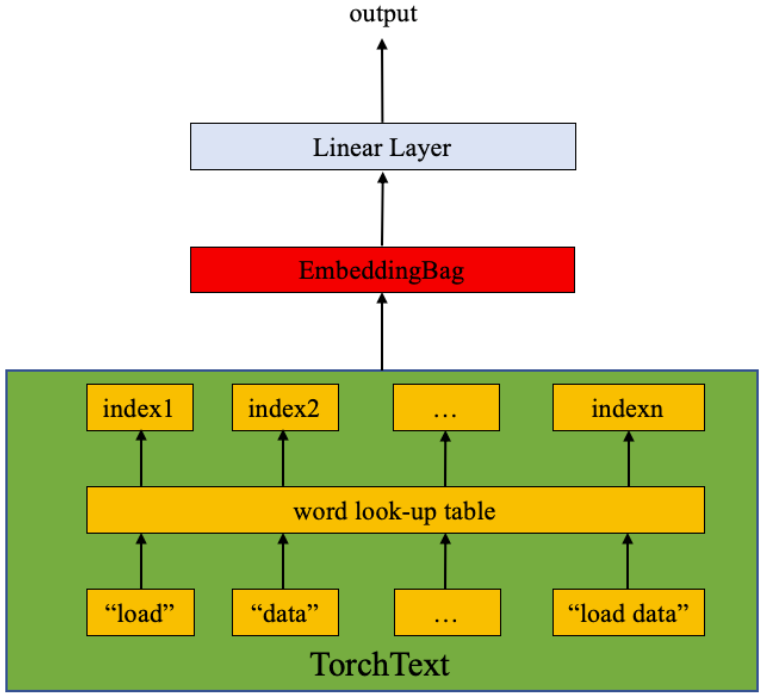


In [74]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.fc = nn.Linear(embedding_dim, 1)
        
    def forward(self, text):
        # text : {maximum review length in the batch, batch size}
        embedded = self.embedding(text)      # embedded : {maximum review length in the batch, batch size, emb dim}
        hidden = torch.sum(embedded, dim=0)  # hidden: [batch_size, emb]
        out = self.fc(hidden)                # out: [batch_size, 1]
        out = out.squeeze(0)                     # out: [batch_size]
        
        return out

Initialise the model

In [75]:
VOCAB_SIZE = len(TEXT.vocab)
EMBEDDING_DIM = 100
model = LogisticRegression(VOCAB_SIZE, EMBEDDING_DIM)

Check the number of parameter in the model

In [76]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has {:,} traninable parameters'.format(count_parameters(model)))

The model has 2,500,301 traninable parameters


Set up training optimizerm cirterion/ loss function

In [77]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-4)

criterion = nn.BCEWithLogitsLoss()  
# Applies sigmoid to the raw outputs, follow ny the BCELoss, 
# !!! DO NOT NEED TO ADD SIGMOID FUNC IN THE MODEL

model = model.to(device)
criterion = criterion.to(device)

Define a function to get accuracy

In [83]:
def binary_accuracy(pred, y):
    '''
    Returns accuracy per bath, i.e. if you get 8/10, ir return 0.8
    '''
    
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(pred))
    correct = (rounded_preds == y).float() # convert into float division
    acc = correct.sum() / len(correct)
    return acc 

## 3. Define train and evaluation function

In [104]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad() # reset the grad to zero for every backprogration 
        pred = model(batch.text).squeeze(1)
        
        loss = criterion(pred, batch.label)
        acc= binary_accuracy(pred, batch.label)
        
        # where optimization is done
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

        

In [108]:
def evaluate(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for batch in iterator:
         
            pred = model(batch.text).squeeze(1)
        
            loss = criterion(pred, batch.label)
            acc= binary_accuracy(pred, batch.label)
        
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [116]:
# function to track time

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## 4. Train the model

In [121]:
N_EPOCH = 10

# store best validation epoch loss
best_valid_loss = float('inf')

for epoch in range(N_EPOCH):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, optimizer, criterion)
    
    end_time = time.time()
    
    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print('-' * 40)
    print('| End of epoch: {:3d} | Epoch time: {}m {}s'. format(epoch+1, elapsed_mins, elapsed_secs))
    print('=' * 40)
    print('| Train Loss: {:5.3f} | Train Acc: {:5.2f}%'. format(train_loss, train_acc*100))
    print('| Val.  Loss: {:5.3f} | Val.  Acc: {:5.2f}%'. format(valid_loss, valid_acc*100))

----------------------------------------
| End of epoch:   1 | Epoch time: 0m 12s
| Train Loss: 0.734 | Train Acc: 64.62%
| Val.  Loss: 1.363 | Val.  Acc: 53.48%
----------------------------------------
| End of epoch:   2 | Epoch time: 0m 12s
| Train Loss: 0.719 | Train Acc: 64.69%
| Val.  Loss: 0.678 | Val.  Acc: 64.66%
----------------------------------------
| End of epoch:   3 | Epoch time: 0m 12s
| Train Loss: 0.721 | Train Acc: 64.66%
| Val.  Loss: 0.636 | Val.  Acc: 67.35%
----------------------------------------
| End of epoch:   4 | Epoch time: 0m 12s
| Train Loss: 0.728 | Train Acc: 64.71%
| Val.  Loss: 0.675 | Val.  Acc: 66.20%
----------------------------------------
| End of epoch:   5 | Epoch time: 0m 12s
| Train Loss: 0.732 | Train Acc: 64.25%
| Val.  Loss: 0.617 | Val.  Acc: 67.82%
----------------------------------------
| End of epoch:   6 | Epoch time: 0m 12s
| Train Loss: 0.708 | Train Acc: 64.83%
| Val.  Loss: 0.967 | Val.  Acc: 57.59%
----------------------------

## 5. Test the network

In [124]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, optimizer, criterion)

print('| Test  Loss: {:5.3f} | Test  Acc: {:5.2f}%'. format(test_loss, test_acc*100))

| Test  Loss: 0.611 | Test  Acc: 67.78%


### Thanks for reading!